In [559]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

In [560]:
local_dir = os.getcwd()
#data_path = COSTUM_DATA_LOCATION
#model_path = COSTUM_MODEL_LOCATION
data_path = os.path.join(os.path.dirname(os.path.dirname(local_dir)),'data')
model_path = os.path.join(os.path.dirname(local_dir),'models')

## 0) Reading data

In [15]:
#df = pd.read_excel("sqf-2020.xlsx") #Full Data set
df = pd.read_csv(os.path.join(data_path,"train_raw.csv")) #Training Data set

## 1) Train test split

In [562]:
%%script echo skipping
df = pd.read_excel(os.path.join(data_path,"sqf-2020.xlsx"))
train, test = train_test_split(df, test_size = 0.2, random_state=14)

train.to_csv(os.path.join(data_path, 'train_raw.csv'), index = False)
test.to_csv(os.path.join(data_path, 'test_raw.csv'), index = False)

Couldn't find program: 'echo'


## 2) Basic Inspection/Cleaning/Description

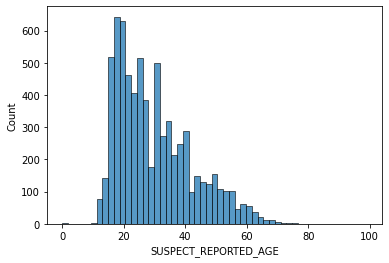

In [563]:
df['SUSPECT_REPORTED_AGE'] = df['SUSPECT_REPORTED_AGE'].replace(' ', np.NaN)
df['SUSPECT_REPORTED_AGE'] = df['SUSPECT_REPORTED_AGE'].apply(pd.to_numeric)
sns.histplot(df['SUSPECT_REPORTED_AGE'])

df.loc[df['SUSPECT_REPORTED_AGE'] < 5,'SUSPECT_REPORTED_AGE'] = np.nan

6525    8.8
7456    8.8
Name: SUSPECT_HEIGHT, dtype: float64
7389    2.5
Name: SUSPECT_HEIGHT, dtype: float64


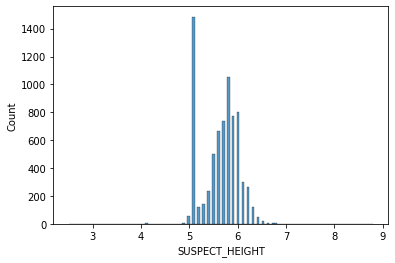

In [564]:
# Set impossible heights to na. 

df['SUSPECT_HEIGHT'] = df['SUSPECT_HEIGHT'].replace(' ', np.NaN)
df['SUSPECT_HEIGHT'] = df['SUSPECT_HEIGHT'].apply(pd.to_numeric)
sns.histplot(df['SUSPECT_HEIGHT'])

print(df.SUSPECT_HEIGHT[df['SUSPECT_HEIGHT'] > 8])
print(df.SUSPECT_HEIGHT[df['SUSPECT_HEIGHT'] < 4])
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
 #   print(df.iloc[[7389]])

df.loc[df['SUSPECT_HEIGHT'] > 8,'SUSPECT_HEIGHT'] = np.nan
df.loc[df['SUSPECT_HEIGHT'] < 4,'SUSPECT_HEIGHT'] = np.nan

208      1.0
261      8.0
422      8.0
647      2.0
727      2.0
986     10.0
2179     8.0
2201     9.0
2596     8.0
3027     0.0
3449     6.0
3767     9.0
3785     8.0
4369     1.0
4608     0.0
4727     1.0
5321    11.0
6185     6.0
6453     1.0
6458     8.0
6653     0.0
7052    20.0
7389     9.0
Name: SUSPECT_WEIGHT, dtype: float64


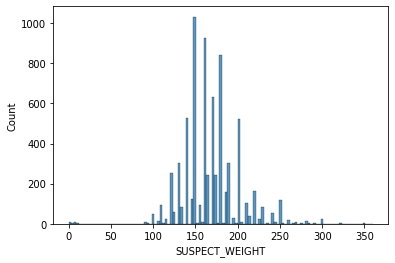

In [565]:
# Set impossible weights to na. 

df['SUSPECT_WEIGHT'] = df['SUSPECT_WEIGHT'].replace(' ', np.NaN)
df['SUSPECT_WEIGHT'] = df['SUSPECT_WEIGHT'].apply(pd.to_numeric)
sns.histplot(df['SUSPECT_WEIGHT'])

print(df.SUSPECT_WEIGHT[df['SUSPECT_WEIGHT'] < 30])
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
 #   print(df.iloc[[986]])

df.loc[df['SUSPECT_WEIGHT'] < 30,'SUSPECT_WEIGHT'] = np.nan

For all categorical variables, the unique values are looked at. Some interesting things to be noted: 
- Missing values are often defined using '(null)' , sometimes also: '', 'XXX', ... , '(', nan
- "Demeanor of person" has incredible amount of categorical values. Some kind of processing technique (maybe NLP-process) will have to be applied here to further use this variable. + has nan as missing value
- Some categorical values have to be transformed into numerical values like: age, height & weight
- Age is the numerical target value. It has missing values indicated as empty strings. Needs to be taken into consideration in later

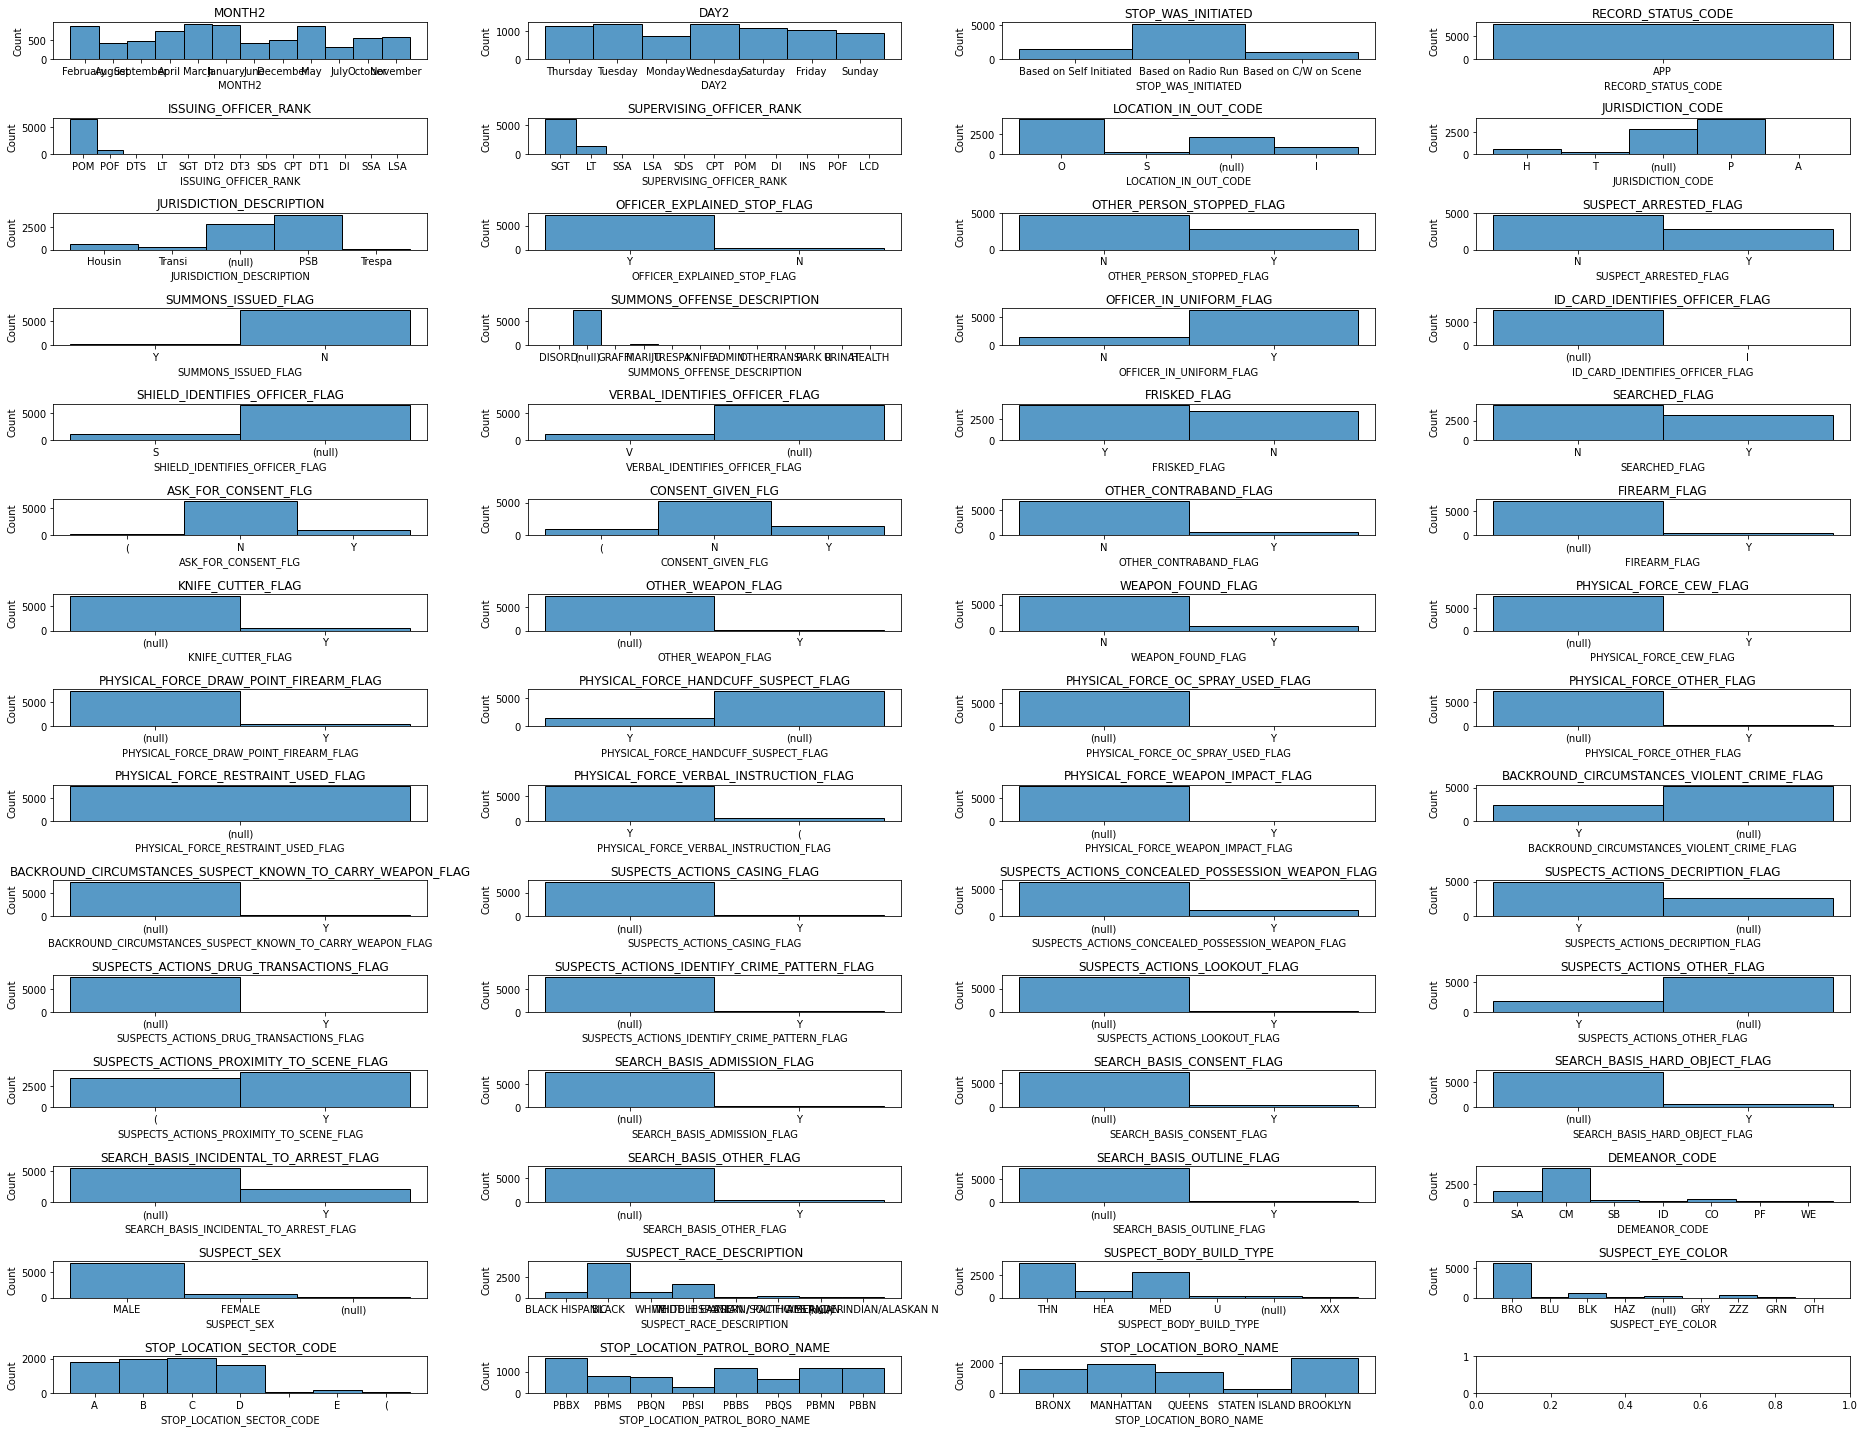

In [566]:
categorical_to_plot = []
num_to_plot = []
for column in df.columns:
    if df[column].dtype == 'object':
        if len(df[column].unique()) < 15:
            categorical_to_plot.append(column) 
    else:
        num_to_plot.append(column)

fig, axes = plt.subplots(15,4,figsize=(26,20))

for idx, col in enumerate(categorical_to_plot):
    ax = axes.reshape(-1)[idx]
    sns.histplot(x=col,data=df,ax=ax)
    t = ax.set_title(col)
plt.tight_layout()

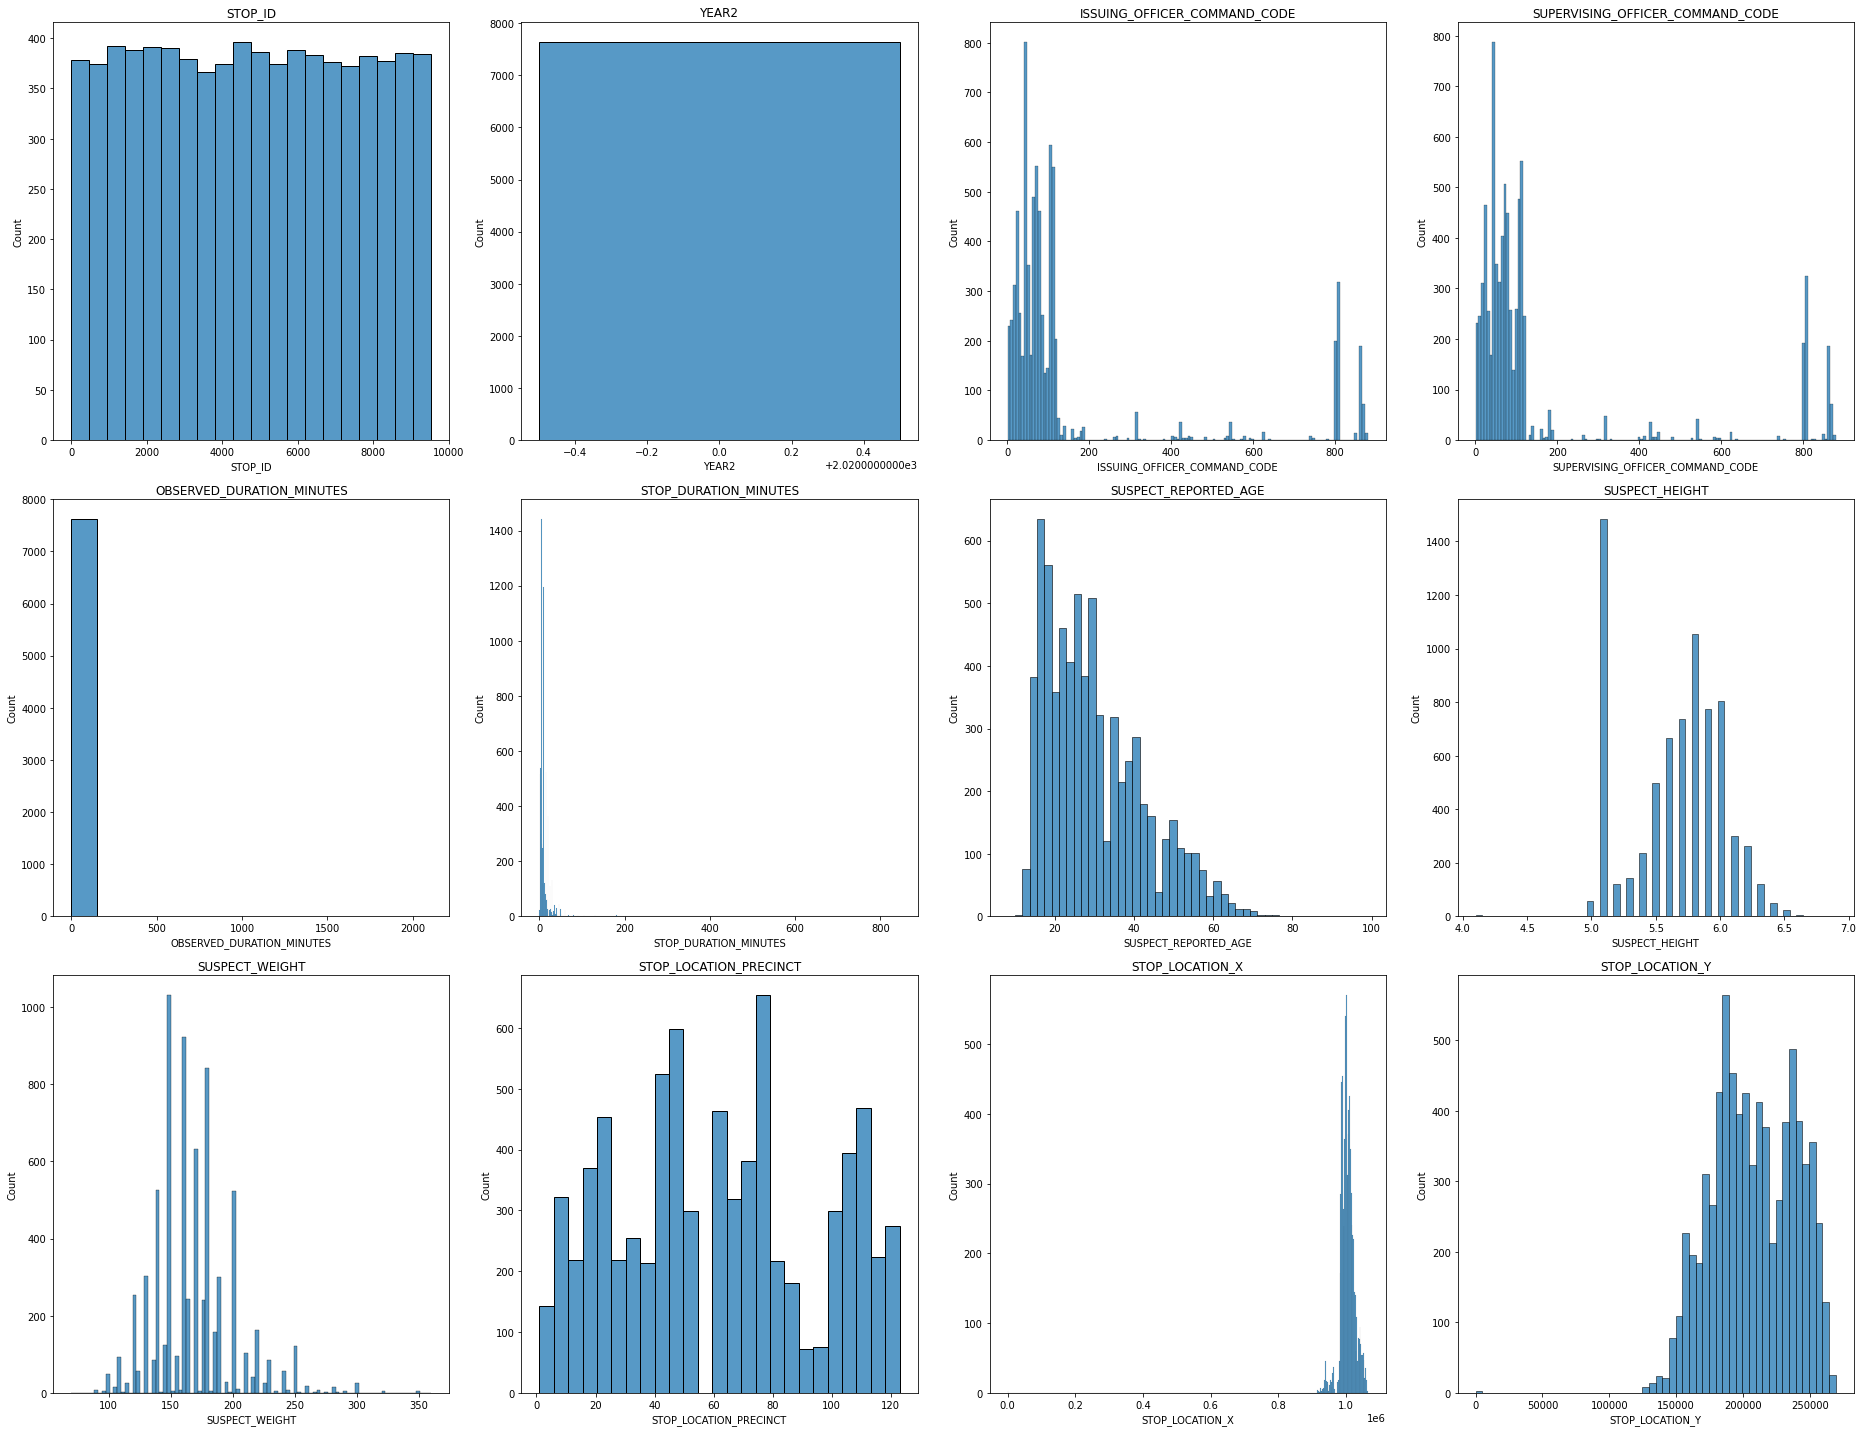

In [567]:
fig, axes = plt.subplots(3,4,figsize=(26,20))

for idx, col in enumerate(num_to_plot):
    ax = axes.reshape(-1)[idx]
    sns.histplot(x=col,data=df,ax=ax)
    t = ax.set_title(col)
plt.tight_layout()

## 3) Missing Values

Following an inspection of the data set, it becomes clear that missing values may be marked in different ways. Candidates are: (null), '(' & ' '. For each category it is investigated if it actually implies missingness and if so set to NA otherwise renamed accordingly.

In [568]:
def val_occurence_per_col(val, dataframe):
    res = {}
    for col in dataframe.columns:
        res[col] = len(dataframe[dataframe[col] == val])

    names = list(res.keys())
    values = list(res.values())

    plt.bar(range(len(res)), values, tick_label=names)
    plt.show()

    of_interest = {key: value for key, value in res.items() if value > 0}

    return of_interest

First, '(null)' is looked at. This is by for the most frequent occurring candidate for missing values. However, for all 'flag' variables, this simply means 'N' instead of '(none)', such that this is renamed accordingly. For the following columns, the (null) variables suggest just being missing values and are thus set to NA: ['LOCATION_IN_OUT_CODE', 'JURISDICTION_CODE', 'JURISDICTION_DESCRIPTION', 'OFFICER_NOT_EXPLAINED_STOP_DESCRIPTION', 'SUSPECT_ARREST_OFFENSE', 'SUMMONS_OFFENSE_DESCRIPTION', 'SUSPECT_SEX', 'SUSPECT_RACE_DESCRIPTION', 'SUSPECT_BODY_BUILD_TYPE', 'SUSPECT_EYE_COLOR', 'SUSPECT_OTHER_DESCRIPTION', 'STOP_LOCATION_APARTMENT', 'STOP_LOCATION_ZIP_CODE']. 

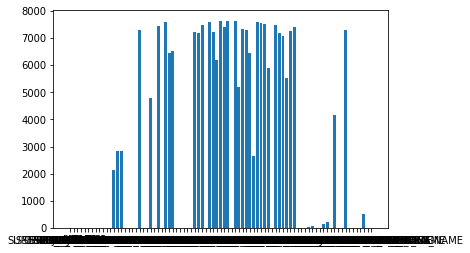

{'LOCATION_IN_OUT_CODE': 2140,
 'JURISDICTION_CODE': 2835,
 'JURISDICTION_DESCRIPTION': 2835,
 'OFFICER_NOT_EXPLAINED_STOP_DESCRIPTION': 7305,
 'SUSPECT_ARREST_OFFENSE': 4780,
 'SUMMONS_OFFENSE_DESCRIPTION': 7433,
 'ID_CARD_IDENTIFIES_OFFICER_FLAG': 7595,
 'SHIELD_IDENTIFIES_OFFICER_FLAG': 6432,
 'VERBAL_IDENTIFIES_OFFICER_FLAG': 6526,
 'FIREARM_FLAG': 7217,
 'KNIFE_CUTTER_FLAG': 7176,
 'OTHER_WEAPON_FLAG': 7489,
 'PHYSICAL_FORCE_CEW_FLAG': 7604,
 'PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG': 7237,
 'PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG': 6172,
 'PHYSICAL_FORCE_OC_SPRAY_USED_FLAG': 7632,
 'PHYSICAL_FORCE_OTHER_FLAG': 7409,
 'PHYSICAL_FORCE_RESTRAINT_USED_FLAG': 7635,
 'PHYSICAL_FORCE_WEAPON_IMPACT_FLAG': 7634,
 'BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG': 5187,
 'BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG': 7332,
 'SUSPECTS_ACTIONS_CASING_FLAG': 7301,
 'SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG': 6447,
 'SUSPECTS_ACTIONS_DECRIPTION_FLAG': 2640,
 'SUSPECTS_ACTIONS_D

In [569]:
val_occurence_per_col('(null)', df)

In [570]:
to_na = ['LOCATION_IN_OUT_CODE', 'JURISDICTION_CODE', 'JURISDICTION_DESCRIPTION', 'OFFICER_NOT_EXPLAINED_STOP_DESCRIPTION', 'SUSPECT_ARREST_OFFENSE', 'SUMMONS_OFFENSE_DESCRIPTION', 'SUSPECT_SEX', 'SUSPECT_RACE_DESCRIPTION', 'SUSPECT_BODY_BUILD_TYPE', 'SUSPECT_EYE_COLOR', 'SUSPECT_OTHER_DESCRIPTION', 'STOP_LOCATION_APARTMENT', 'STOP_LOCATION_ZIP_CODE']
to_N = ['ID_CARD_IDENTIFIES_OFFICER_FLAG', 'SHIELD_IDENTIFIES_OFFICER_FLAG', 'VERBAL_IDENTIFIES_OFFICER_FLAG', 'FIREARM_FLAG', 'KNIFE_CUTTER_FLAG', 'OTHER_WEAPON_FLAG', 'PHYSICAL_FORCE_CEW_FLAG', 'PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG', 'PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG', 'PHYSICAL_FORCE_OC_SPRAY_USED_FLAG', 'PHYSICAL_FORCE_OTHER_FLAG', 'PHYSICAL_FORCE_RESTRAINT_USED_FLAG', 'PHYSICAL_FORCE_WEAPON_IMPACT_FLAG', 'BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG', 'BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG', 'SUSPECTS_ACTIONS_CASING_FLAG', 'SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG', 'SUSPECTS_ACTIONS_DECRIPTION_FLAG', 'SUSPECTS_ACTIONS_DRUG_TRANSACTIONS_FLAG', 'SUSPECTS_ACTIONS_IDENTIFY_CRIME_PATTERN_FLAG', 'SUSPECTS_ACTIONS_LOOKOUT_FLAG', 'SUSPECTS_ACTIONS_OTHER_FLAG', 'SEARCH_BASIS_ADMISSION_FLAG', 'SEARCH_BASIS_CONSENT_FLAG', 'SEARCH_BASIS_HARD_OBJECT_FLAG', 'SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG', 'SEARCH_BASIS_OTHER_FLAG', 'SEARCH_BASIS_OUTLINE_FLAG']

for col in to_na:
    df.loc[df[col] == '(null)', col] = np.NaN

for col in to_N:
    df.loc[df[col] == '(null)', col] = 'N'

Next, '(' is looked at. As for 'ASK_FOR_CONSENT_FLG' and 'CONSENT_GIVEN_FLG', this is the third option next to 'Y' and 'N', '(' most likely represents a missing value and is thus set to NA. For the next two flags, however, it is the second option next to 'Y' and thus most likely means 'N' and is thus set accordingly. For the 'STOP_LOCATION_SECTOR_CODE', it is one of the many factor levels and thus means missing and is set to NA. 

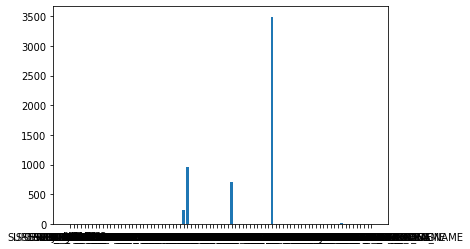

{'ASK_FOR_CONSENT_FLG': 234,
 'CONSENT_GIVEN_FLG': 958,
 'PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG': 712,
 'SUSPECTS_ACTIONS_PROXIMITY_TO_SCENE_FLAG': 3492,
 'STOP_LOCATION_SECTOR_CODE': 23}

In [571]:
val_occurence_per_col('(', df)

In [572]:
to_na = ['ASK_FOR_CONSENT_FLG', 'CONSENT_GIVEN_FLG', 'STOP_LOCATION_SECTOR_CODE']
to_N = ['PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG', 'SUSPECTS_ACTIONS_PROXIMITY_TO_SCENE_FLAG']

for col in to_na:
    df.loc[df[col] == '(', col] = np.NaN

for col in to_N:
    df.loc[df[col] == '(', col] = 'N'

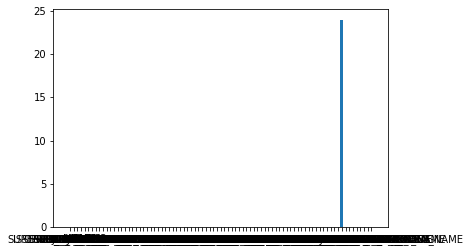

{'STOP_LOCATION_SECTOR_CODE': 24}

In [573]:
val_occurence_per_col(' ', df)

Next, ' ' is looked at. In all cases these represent missing values and are thus set to NA. 

In [574]:
to_na = ['SUSPECT_HEIGHT', 'SUSPECT_WEIGHT', 'STOP_LOCATION_SECTOR_CODE']

for col in to_na:
    df.loc[df[col] == ' ', col] = np.NaN

Now also some error hunting:

In [575]:
df.loc[df['SUSPECT_BODY_BUILD_TYPE'] == 'XXX', 'SUSPECT_BODY_BUILD_TYPE'] = 'unknown'
df.loc[df['SUSPECT_EYE_COLOR'] == 'ZZZ', 'SUSPECT_EYE_COLOR'] = 'unknown'
df.loc[df['SUSPECT_HAIR_COLOR'] == '(nu', 'SUSPECT_HAIR_COLOR'] = 'unknown'
df.loc[df['SUSPECT_HAIR_COLOR'] == 'ZZZ', 'SUSPECT_HAIR_COLOR'] = 'unknown'

Now that all actual missing values are found, the missingness mechanism is looked in to. This is done with the missingno package. The bar plot shows that a few columns have so little values. Therefore, ommitting these may be adviced. However, the relevance of a column to the target variable must be kept in mind. Therefore it is decided to immediately ommit columns with less than 0.05 pearson correlation to both of the target variables and more than 0.30 missing. In this case these variables are: stop_location_appartement, summons_offense_description, location_in_and_out_code, jurisdiction_code and jurisdiction_description. The heatmap shows the missingness correlations, indicating some expected correlations like if the weight is not given, the height is neither. The most suprising but not too influencial missingness correlation is between sex and race.

Next it is looked into if some rows contain a lot of missing values at once. 

In [576]:
to_delete = ['STOP_LOCATION_APARTMENT', 'SUMMONS_OFFENSE_DESCRIPTION', 'JURISDICTION_CODE', 'JURISDICTION_DESCRIPTION', 'LOCATION_IN_OUT_CODE', 'OFFICER_NOT_EXPLAINED_STOP_DESCRIPTION', 'STOP_LOCATION_SECTOR_CODE']
df = df.drop(labels = to_delete, axis = 1)
rows_to_drop = df[df['SUSPECT_RACE_DESCRIPTION'].isna()].index
df = df.drop(index=rows_to_drop)

<AxesSubplot:>

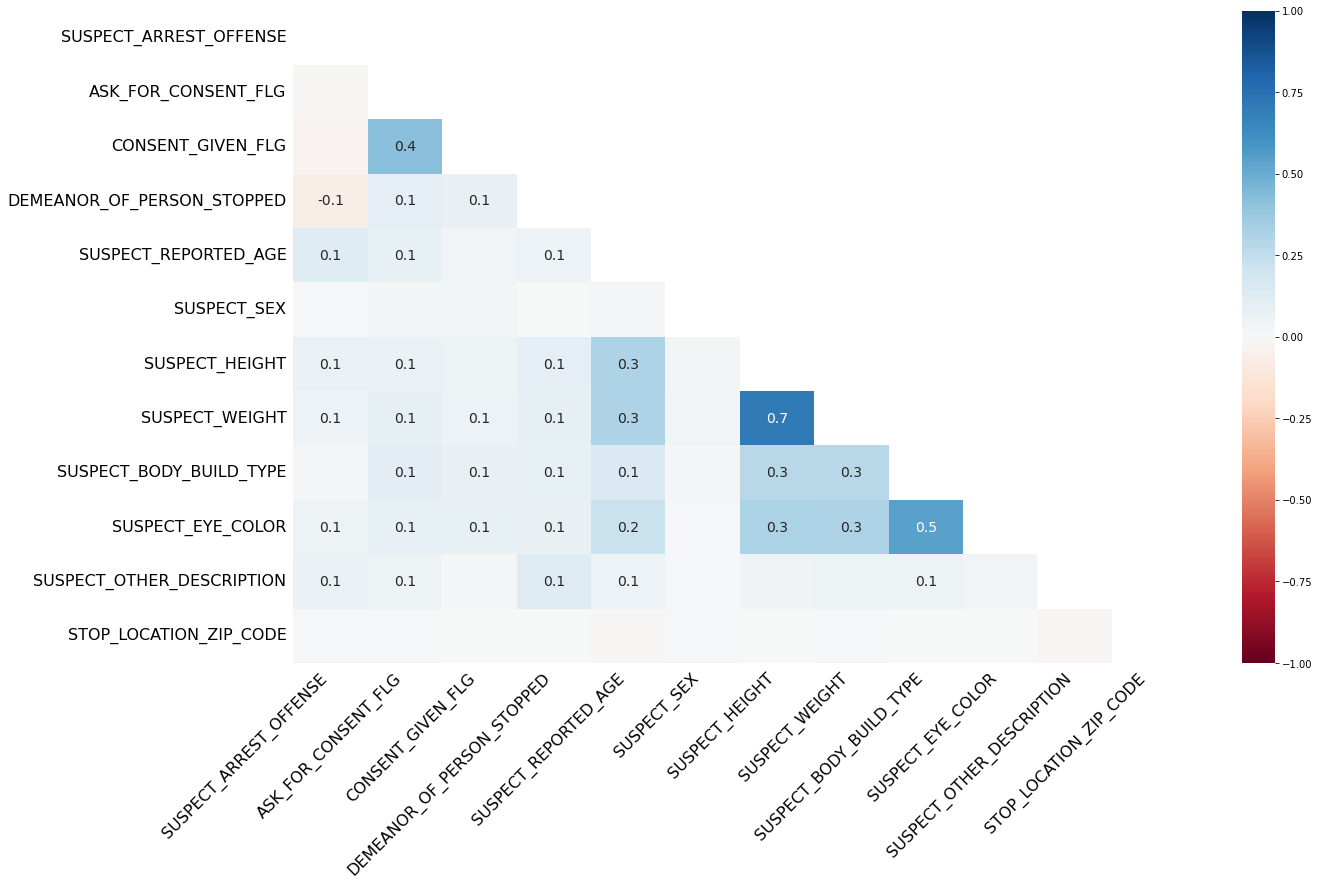

In [577]:
missingno.heatmap(df)

In [578]:
df.loc[df['SUSPECT_BODY_BUILD_TYPE'] == 'XXX', 'SUSPECT_BODY_BUILD_TYPE'] = 'unknown'
df.loc[df['SUSPECT_EYE_COLOR'] == 'ZZZ', 'SUSPECT_EYE_COLOR'] = 'unknown'
df.loc[df['SUSPECT_HAIR_COLOR'] == '(nu', 'SUSPECT_HAIR_COLOR'] = 'unknown'
df.loc[df['SUSPECT_HAIR_COLOR'] == 'ZZZ', 'SUSPECT_HAIR_COLOR'] = 'unknown'
df['DEMEANOR_OF_PERSON_STOPPED'] = df['DEMEANOR_OF_PERSON_STOPPED'].fillna('empty')
df.loc[df['SUSPECT_OTHER_DESCRIPTION'].isna(), 'SUSPECT_OTHER_DESCRIPTION'] = 'empty'
df.loc[df['CONSENT_GIVEN_FLG'].isna(), 'CONSENT_GIVEN_FLG'] = 'empty'
df.loc[df['ASK_FOR_CONSENT_FLG'].isna(), 'ASK_FOR_CONSENT_FLG'] = 'empty'
df.loc[df['SUSPECT_ARREST_OFFENSE'].isna(), 'SUSPECT_ARREST_OFFENSE'] = 'not arrested'
df.loc[df['SUSPECT_SEX'].isna(), 'SUSPECT_SEX'] = 'unknown'
df.loc[df['SUSPECT_BODY_BUILD_TYPE'].isna(), 'SUSPECT_BODY_BUILD_TYPE'] = 'unknown'
df.loc[df['SUSPECT_EYE_COLOR'].isna(), 'SUSPECT_EYE_COLOR'] = 'unknown'
df.loc[df['SUSPECT_HAIR_COLOR'].isna(), 'SUSPECT_HAIR_COLOR'] = 'unknown'
df.loc[df['STOP_LOCATION_ZIP_CODE'].isna(), 'STOP_LOCATION_ZIP_CODE'] = 'unknown'

0.0
None


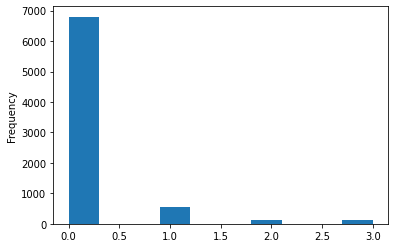

In [579]:
missing_rows = df.isnull().sum(axis=1).sort_values(axis = 0, ascending = False)
missing_rows.plot(kind='hist')

missingness = print(len(missing_rows[missing_rows >= 6])/df.shape[0])
print(missingness)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
       df.loc[508,:]

Imputation for Age, Height and Weight!

In [580]:
%%script echo skipping
from dython.nominal import associations
complete_correlation= associations(df, filename= 'complete_age_correlation.png', figsize=(50,50), display_rows=['SUSPECT_REPORTED_AGE'])

Couldn't find program: 'echo'


In [590]:
df.shape

(7570, 76)

In [591]:
print(df['SUSPECT_REPORTED_AGE'].isna().sum()/7570)
print(df['SUSPECT_WEIGHT'].isna().sum()/7570)
print(df['SUSPECT_HEIGHT'].isna().sum()/7570)

0.07582562747688243
0.03989431968295905
0.031968295904887714


In [529]:
good_predictors = ['SUSPECT_REPORTED_AGE', 'SUSPECT_RACE_DESCRIPTION', 'SUSPECT_HEIGHT', 
                        'SUSPECT_WEIGHT', 'SUSPECT_BODY_BUILD_TYPE', 'SUSPECT_HAIR_COLOR', 
                        'STOP_LOCATION_ZIP_CODE', 'STOP_LOCATION_PATROL_BORO_NAME']
df_impute = df[good_predictors]
df_impute = pd.get_dummies(df_impute)

imputer = KNNImputer(n_neighbors=3)
res = imputer.fit_transform(df_impute)
res
age = []
height = []
weight = []
for rows in res:
    age.append(round(rows[0]))
    weight.append(round(rows[2]))
    height.append(rows[1])

df['SUSPECT_REPORTED_AGE'] = age
df['SUSPECT_WEIGHT'] = weight
df['SUSPECT_HEIGHT'] = height

<AxesSubplot:>

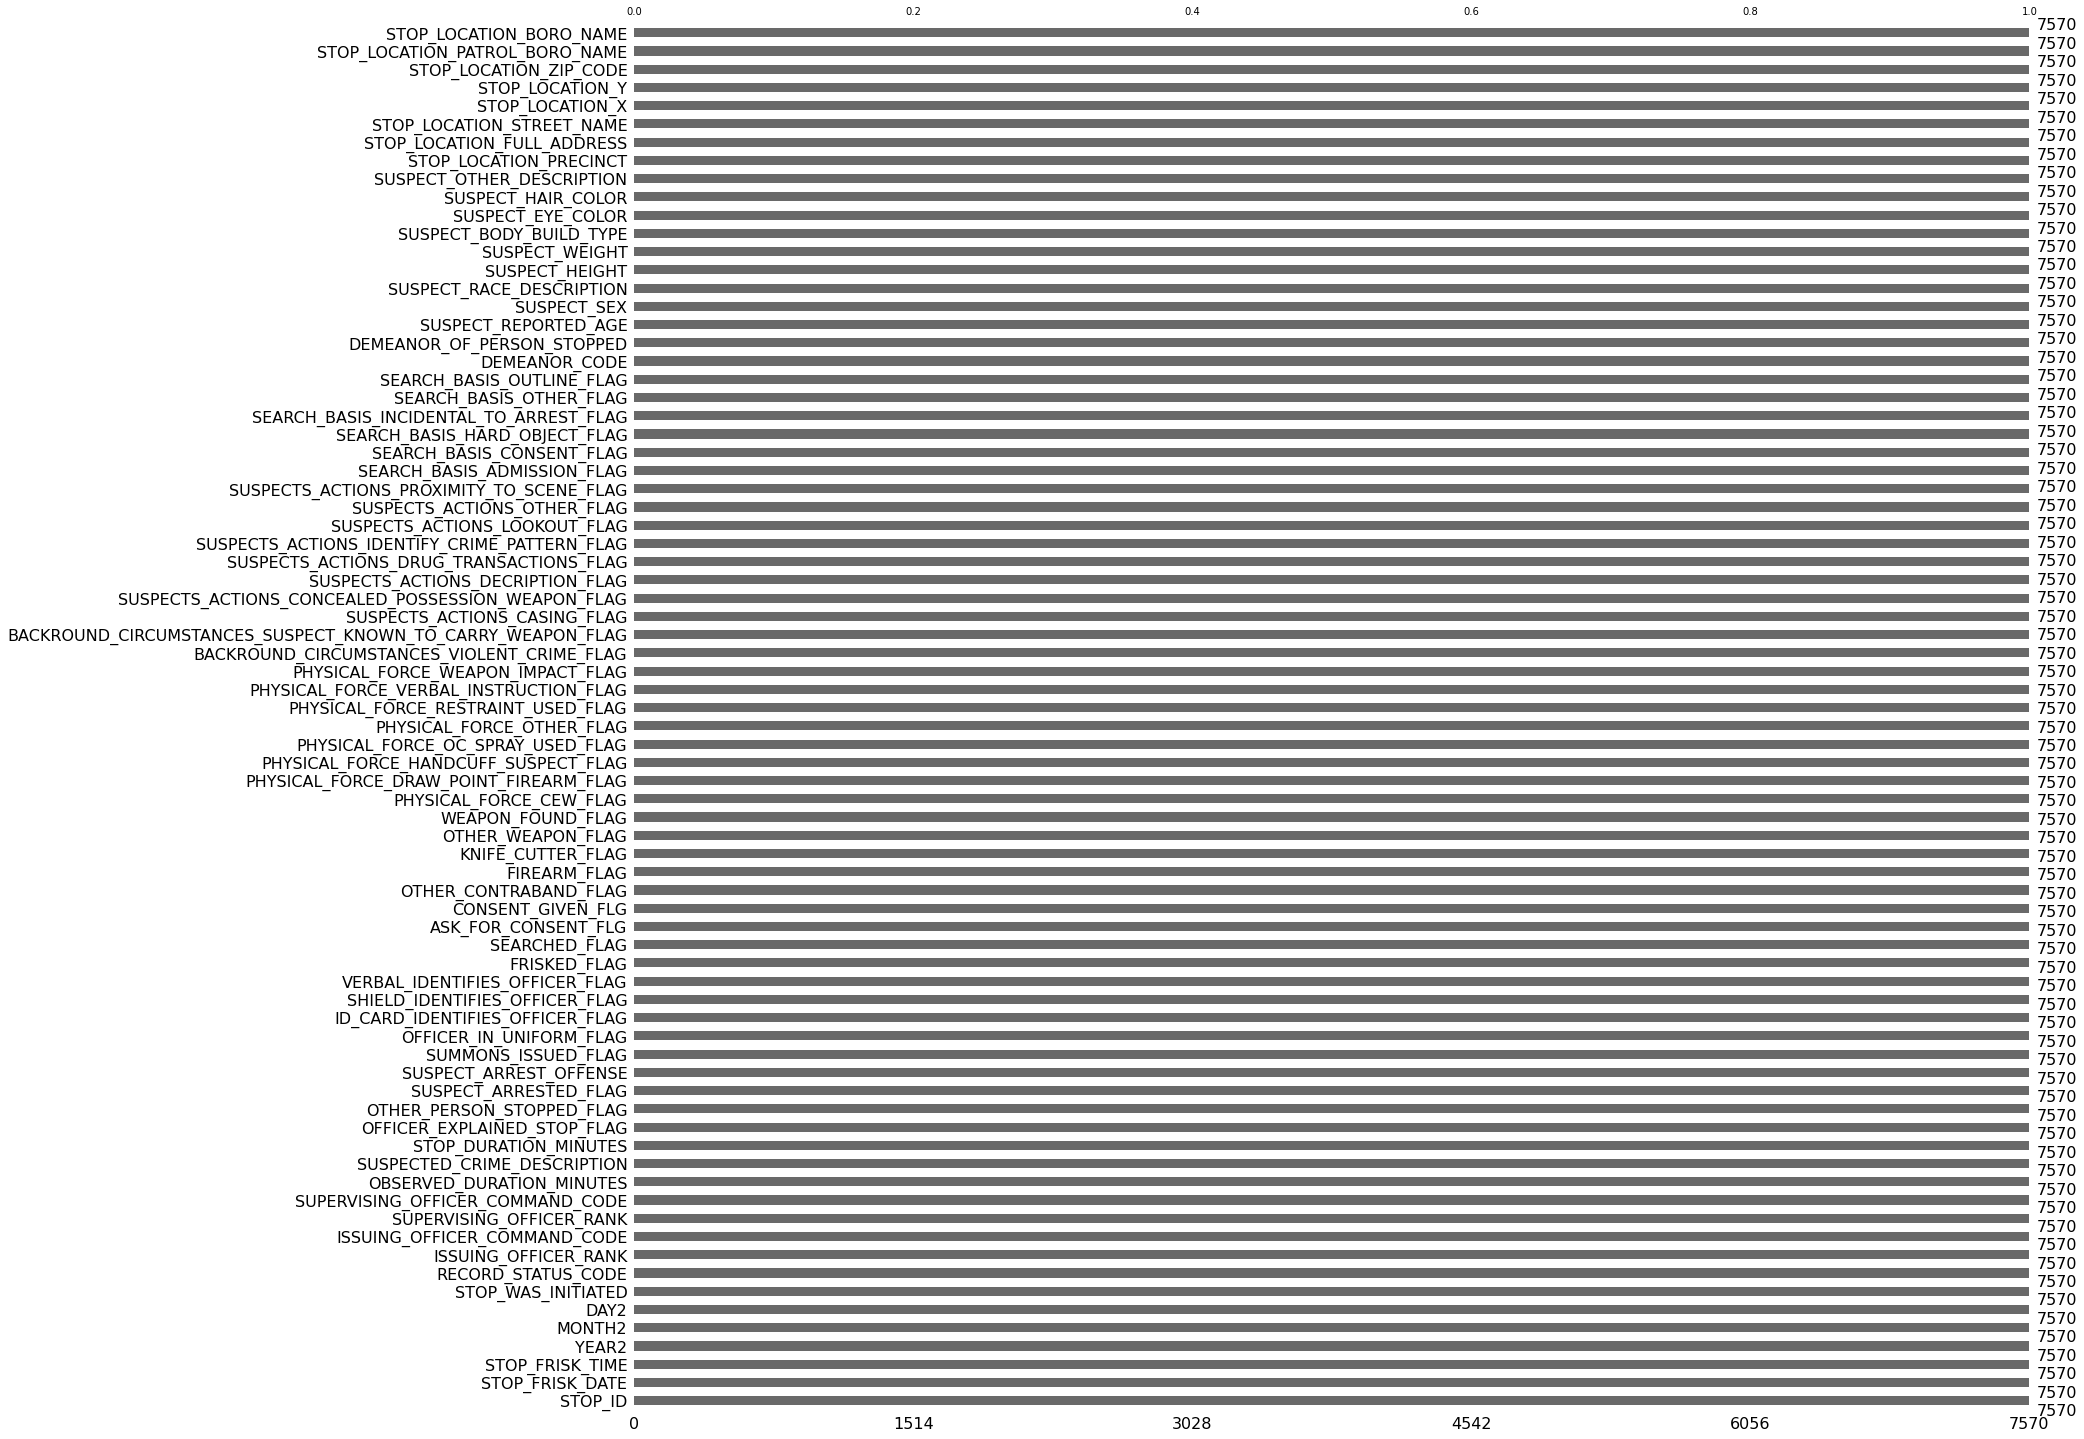

In [530]:
missingno.bar(df)

## 4) Outliers

0
491


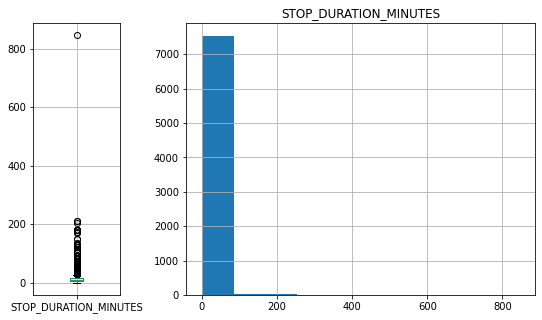

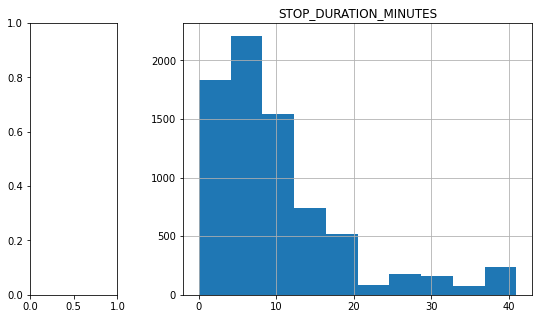

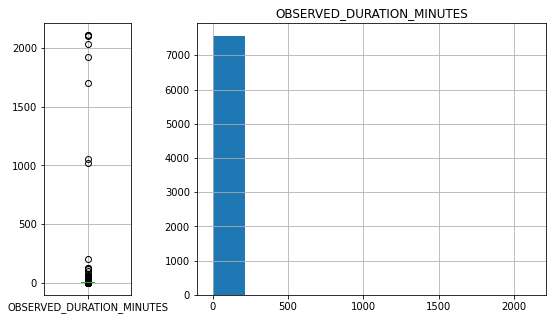

In [531]:
## Alex

from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates

fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
df.boxplot(column='STOP_DURATION_MINUTES',ax=axes[0]);
df.hist(column='STOP_DURATION_MINUTES', ax=axes[1]);

Q1 = df['STOP_DURATION_MINUTES'].quantile(0.25)
Q3 = df['STOP_DURATION_MINUTES'].quantile(0.75)
IQR = Q3 - Q1


small_outliers = df['STOP_DURATION_MINUTES'] < (Q1 - 1.5 * IQR) #no small outliers
big_outliers = df['STOP_DURATION_MINUTES'] > (Q3 + 1.5 * IQR)
extreme_big_outliers = df['STOP_DURATION_MINUTES'] > (Q3 + 3 * IQR)
df.loc[(df.STOP_DURATION_MINUTES > (Q3 + 3 * IQR)),'STOP_DURATION_MINUTES']=(Q3 + 3 * IQR)

print(sum(small_outliers)), print(sum(big_outliers))

fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
df.hist(column='STOP_DURATION_MINUTES', ax=axes[1]);

fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
df.boxplot(column='OBSERVED_DURATION_MINUTES',ax=axes[0]);
df.hist(column='OBSERVED_DURATION_MINUTES', ax=axes[1]);

Q1 = df['OBSERVED_DURATION_MINUTES'].quantile(0.25)
Q3 = df['OBSERVED_DURATION_MINUTES'].quantile(0.75)
IQR = Q3 - Q1


small_outliers = df['OBSERVED_DURATION_MINUTES'] < (Q1 - 1.5 * IQR)
big_outliers = df['OBSERVED_DURATION_MINUTES'] > (Q3 + 1.5 * IQR)
extreme_big_outliers = df['OBSERVED_DURATION_MINUTES'] > (Q3 + 3 * IQR)
df.loc[(df.OBSERVED_DURATION_MINUTES > 1),'IMMEDIATE_STOP_FLAG']= 'N'
df.loc[(df.OBSERVED_DURATION_MINUTES <= 1),'IMMEDIATE_STOP_FLAG']= 'Y'

df = df.drop(labels = ['OBSERVED_DURATION_MINUTES'], axis=1)

Text(0.5, 0, 'IMMEDIATE STOP FLAG')

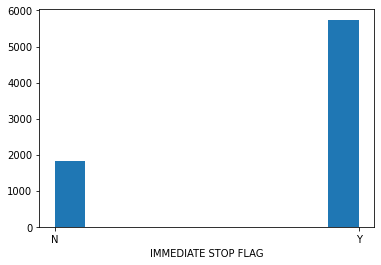

In [532]:
plt.hist(df['IMMEDIATE_STOP_FLAG'])
plt.xlabel('IMMEDIATE STOP FLAG')

We also plot the timestamp variable to see if there are any outliers.

time    datetime64[ns]
hour             int64
dtype: object


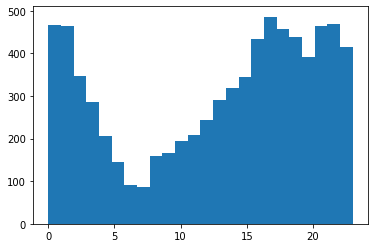

In [533]:
t = {'time': df['STOP_FRISK_TIME']}
t  = pd.DataFrame(data=t)
t['time'] = pd.to_datetime(t['time'], infer_datetime_format='%H%m%s')

t['hour'] = t['time'].dt.strftime('%H')
t[['hour']] = t[['hour']].astype('int64')

print(t.dtypes)

plt.hist(t['hour'], bins=24)
plt.show()

df['STOP_FRISK_TIME_HOUR'] = t['hour']

## 6) Derivation of new veriables

In [534]:
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.cluster import KMeans
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\louis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Deriving a new variable from the suspect demeanor description. 

In [535]:
def nlp_preprocess(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    stemmer = WordNetLemmatizer()
    tok = tokenizer.tokenize(text)
    tok = [str.lower(wrd) for wrd in tok]
    res = [wrd for wrd in tok if wrd not in stopwords.words('english')]
    res = [stemmer.lemmatize(wrd) for wrd in res]
    res = ' '.join(res)
    return res

cleaned_demeanor = []
for descr in df['DEMEANOR_OF_PERSON_STOPPED']:
    cleaned_demeanor.append(nlp_preprocess(descr))

df['cleaned_demeanor'] = cleaned_demeanor

voc = TfidfVectorizer(preprocessor = nlp_preprocess, ngram_range=(1,2), stop_words = 'english', min_df=0.02).fit(df['cleaned_demeanor'])
train_vect = voc.transform(df['cleaned_demeanor'])
df = df.drop(['cleaned_demeanor'], axis = 1)

c:\Users\louis\anaconda3\envs\BDM\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le'] not in stop_words.
  warnings.warn(


Text(0.5, 0, 'K')

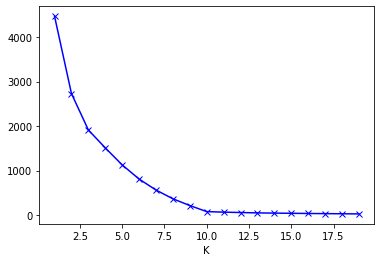

In [536]:
ssq = []
K = range(1,20)
for k in K:
    kmeans = KMeans(n_clusters=k)
    km = kmeans.fit(train_vect)
    ssq.append(km.inertia_)

plt.plot(K, ssq, 'bx-', )
plt.xlabel("K")


In [537]:
kmeans = KMeans(n_clusters=11)
kmeans_res = kmeans.fit(train_vect)
df['KMEANS_DEMEANOR'] = [str(x) for x in kmeans_res.labels_]

In [538]:
list(df[df['KMEANS_DEMEANOR']=='5'].DEMEANOR_OF_PERSON_STOPPED)

['COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'INITIALLY FLED ON FOOT PRIOR TO BEING COOPERATIVE.',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'JOVIAL, COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'VERY COOPERATIVE/UNDERSTANDING',
 'COOPERATIVE',
 'COOPERATIVE',
 'NERVOUS BUT COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE AND APOLOGETIC',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'RELAXED AND COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',

Deriving variables from time/date data

In [539]:
def time_to_float(time):
    hour, minute = time.split(':')[0:2]
    return int(hour) + int(minute)/60

new_time_var = []
for times in df['STOP_FRISK_TIME']:
    new_time_var.append(time_to_float(times))

df['TIME_NUM'] = new_time_var

(array([1083.,  659.,  277.,  337.,  462.,  660.,  893., 1120., 1017.,
        1062.]),
 array([ 0.        ,  2.39833333,  4.79666667,  7.195     ,  9.59333333,
        11.99166667, 14.39      , 16.78833333, 19.18666667, 21.585     ,
        23.98333333]),
 <BarContainer object of 10 artists>)

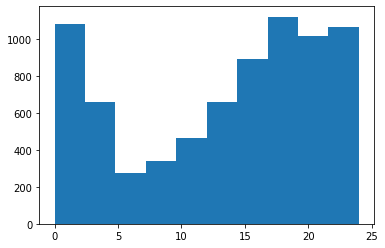

In [540]:
plt.hist(new_time_var)

Collapsing category Levels

In [542]:
## Keep only top 3 officer ranks, rest other. 
levels = df['ISSUING_OFFICER_RANK'].value_counts()
print(levels)
to_keep = levels.index[:3]
print(to_keep)

df.loc[(~df.ISSUING_OFFICER_RANK.isin(to_keep)), 'ISSUING_OFFICER_RANK'] = 'OTHER'
levels = df['ISSUING_OFFICER_RANK'].value_counts()
print(levels)

## Keep only top 2 supervising officer ranks, rest other. 
levels = df['SUPERVISING_OFFICER_RANK'].value_counts()
print(levels)
to_keep = levels.index[:2]
print(to_keep)

df.loc[(~df.SUPERVISING_OFFICER_RANK.isin(to_keep)), 'SUPERVISING_OFFICER_RANK'] = 'OTHER'
levels = df['SUPERVISING_OFFICER_RANK'].value_counts()
print(levels)

## Try simpler race description
levels = df['SUSPECT_RACE_DESCRIPTION'].value_counts()
print(levels)
black = ['BLACK', 'BLACK HISPANIC']
white = ['WHITE', 'WHITE HISPANIC']
rest = black + white

df.loc[(df.SUSPECT_RACE_DESCRIPTION.isin(black)), 'SUSPECT_RACE_DESCRIPTION'] = 'BLACK'
df.loc[(df.SUSPECT_RACE_DESCRIPTION.isin(white)), 'SUSPECT_RACE_DESCRIPTION'] = 'WHITE'
df.loc[(~df.SUSPECT_RACE_DESCRIPTION.isin(rest)), 'SUSPECT_RACE_DESCRIPTION'] = 'OTHER'
levels = df['SUSPECT_RACE_DESCRIPTION'].value_counts()
print(levels)

## Keep only thin, med and heavy. rest is unkown. 
levels = df['SUSPECT_BODY_BUILD_TYPE'].value_counts()
to_keep = levels.index[:3]
print(levels)
df.loc[(~df.SUSPECT_BODY_BUILD_TYPE.isin(to_keep)), 'SUSPECT_BODY_BUILD_TYPE'] = 'UNKNOWN'
levels = df['SUSPECT_BODY_BUILD_TYPE'].value_counts()
print(levels)

#Merge eye color such that simpler
levels = df['SUSPECT_EYE_COLOR'].value_counts()
bro = ['BRO', 'HAZ']
blk = ['BLK']
unknown = ['unkown']
rest = ['BLU', 'GRY', 'GRN', 'OTH']
print(levels)

df.loc[(df.SUSPECT_EYE_COLOR.isin(bro)), 'SUSPECT_EYE_COLOR'] = 'BROWN'
df.loc[(df.SUSPECT_EYE_COLOR.isin(blk)), 'SUSPECT_EYE_COLOR'] = 'BLACK'
df.loc[(df.SUSPECT_EYE_COLOR.isin(unknown)), 'SUSPECT_EYE_COLOR'] = 'UNKNOWN'
df.loc[(df.SUSPECT_EYE_COLOR.isin(rest)), 'SUSPECT_EYE_COLOR'] = 'OTHER'
levels = df['SUSPECT_EYE_COLOR'].value_counts()
print(levels)

## merge hairs for simplicity
levels = df['SUSPECT_HAIR_COLOR'].value_counts()
keep = ['BLK', 'BRO', 'BLD', 'GRY']
unk = ['unknown', 'XXX']
rest = unk + keep
print(levels)

df.loc[(df.SUSPECT_HAIR_COLOR.isin(unk)), 'SUSPECT_HAIR_COLOR'] = 'UNKOWN'
df.loc[(~df.SUSPECT_HAIR_COLOR.isin(rest)), 'SUSPECT_HAIR_COLOR'] = 'OTHER'
levels = df['SUSPECT_HAIR_COLOR'].value_counts()
print(levels)

POM    6379
POF     801
SGT     138
DTS      94
LT       66
DT3      61
CPT      14
DT2       6
SSA       4
SDS       2
DT1       2
DI        2
LSA       1
Name: ISSUING_OFFICER_RANK, dtype: int64
Index(['POM', 'POF', 'SGT'], dtype='object')
POM      6379
POF       801
OTHER     252
SGT       138
Name: ISSUING_OFFICER_RANK, dtype: int64
SGT    5896
LT     1461
SSA      96
LSA      39
CPT      35
POM      13
SDS      12
DI       10
INS       3
LCD       3
POF       2
Name: SUPERVISING_OFFICER_RANK, dtype: int64
Index(['SGT', 'LT'], dtype='object')
SGT      5896
LT       1461
OTHER     213
Name: SUPERVISING_OFFICER_RANK, dtype: int64
BLACK                        4292
WHITE HISPANIC               1648
WHITE                         675
BLACK HISPANIC                646
ASIAN / PACIFIC ISLANDER      185
MIDDLE EASTERN/SOUTHWEST      109
AMERICAN INDIAN/ALASKAN N      15
Name: SUSPECT_RACE_DESCRIPTION, dtype: int64
BLACK    4938
WHITE    2323
OTHER     309
Name: SUSPECT_RACE_DESCRIPTION, dty

## Visualizations

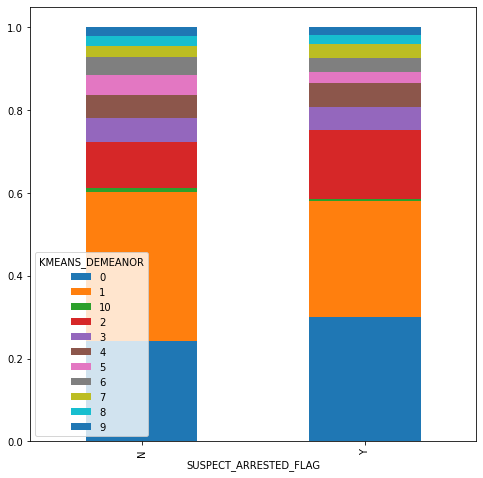

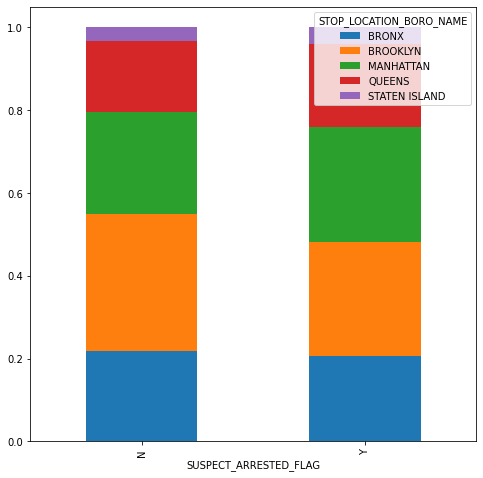

In [545]:
pd.crosstab(df['KMEANS_DEMEANOR'], 
            df['SUSPECT_ARRESTED_FLAG'],
            normalize="columns").T.plot.bar(stacked=True, 
                                            figsize=(8,8));
pd.crosstab(df['STOP_LOCATION_BORO_NAME'], 
            df['SUSPECT_ARRESTED_FLAG'],
            normalize="columns").T.plot.bar(stacked=True, 
                                            figsize=(8,8));

<AxesSubplot:xlabel='SUSPECT_ARRESTED_FLAG', ylabel='STOP_LOCATION_BORO_NAME'>

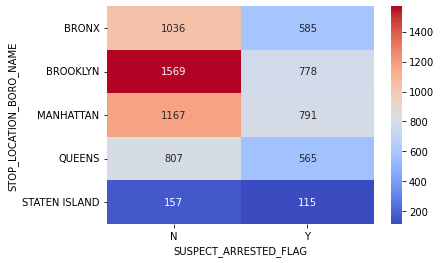

In [546]:
location_arrest = pd.crosstab(df['STOP_LOCATION_BORO_NAME'], df['SUSPECT_ARRESTED_FLAG'])
sns.heatmap(location_arrest, annot=True, fmt="d", cmap='coolwarm')

In [547]:
print(df.SUSPECT_REPORTED_AGE.min());
print(df.SUSPECT_REPORTED_AGE.max());

8
99


In [548]:
Age_cut = pd.cut(df.SUSPECT_REPORTED_AGE, bins=pd.interval_range(start=0, end=100,freq=10, closed='left'))  
df['SUSPECT_REPORTED_AGE_CUT'] = Age_cut.astype('str')

In [549]:
df.SUSPECT_REPORTED_AGE_CUT.value_counts().sort_index()

[0, 10)         1
[10, 20)     1694
[20, 30)     2583
[30, 40)     1717
[40, 50)      901
[50, 60)      519
[60, 70)      137
[70, 80)       16
[90, 100)       2
Name: SUSPECT_REPORTED_AGE_CUT, dtype: int64

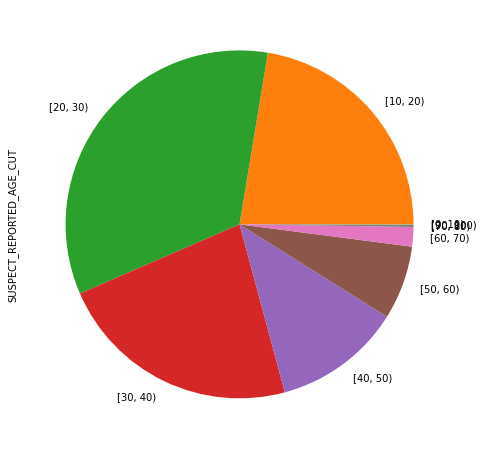

In [550]:
df.SUSPECT_REPORTED_AGE_CUT.value_counts().sort_index().plot.pie(figsize=(8,8));

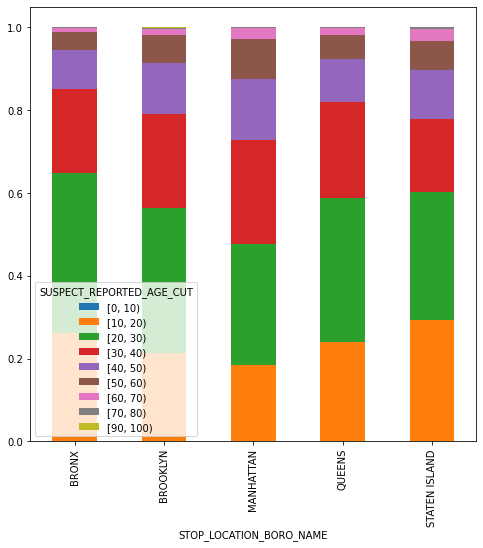

In [551]:
pd.crosstab(df['SUSPECT_REPORTED_AGE_CUT'], 
            df['STOP_LOCATION_BORO_NAME'],
            normalize="columns").T.plot.bar(stacked=True, 
                                            figsize=(8,8));

In [552]:
age_borough = pd.crosstab(df['SUSPECT_REPORTED_AGE_CUT'], 
            df['STOP_LOCATION_BORO_NAME'],
            normalize="columns")

age_borough

STOP_LOCATION_BORO_NAME,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
SUSPECT_REPORTED_AGE_CUT,,,,,
"[0, 10)",0.000000,0.000426,0.000000,0.000000,0.000000
"[10, 20)",0.261567,0.213038,0.184372,0.239796,0.294118
"[20, 30)",0.386798,0.350234,0.292135,0.348397,0.308824
"[30, 40)",0.201727,0.227524,0.250255,0.231778,0.176471
"[40, 50)",0.095620,0.121432,0.147089,0.102770,0.117647
"[50, 60)",0.042566,0.069024,0.096527,0.058309,0.069853
"[60, 70)",0.009870,0.014913,0.028090,0.016764,0.029412
"[70, 80)",0.001851,0.002556,0.001532,0.002187,0.003676
"[90, 100)",0.000000,0.000852,0.000000,0.000000,0.000000


## 8) Rounding up / Pipelining / Writing to csv

Saving Train set

In [553]:
df.to_csv(os.path.join(data_path,'train_preprocessed.csv'))

In [554]:
def nlp_preprocess(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    stemmer = WordNetLemmatizer()
    tok = tokenizer.tokenize(text)
    tok = [str.lower(wrd) for wrd in tok]
    res = [wrd for wrd in tok if wrd not in stopwords.words('english')]
    res = [stemmer.lemmatize(wrd) for wrd in res]
    res = ' '.join(res)
    return res

def time_to_float(time):
    hour, minute = time.split(':')[0:2]
    return int(hour) + int(minute)/60

Pipeline for Test set

In [555]:
def preprocess(dataframe, tfid_voc, kmeans_model):
    # Make Age Numerical 
    dataframe['SUSPECT_REPORTED_AGE'] = dataframe['SUSPECT_REPORTED_AGE'].replace(' ', np.NaN)
    dataframe['SUSPECT_REPORTED_AGE'] = dataframe['SUSPECT_REPORTED_AGE'].apply(pd.to_numeric)
    dataframe.loc[dataframe['SUSPECT_REPORTED_AGE'] < 5,'SUSPECT_REPORTED_AGE'] = np.nan

    dataframe['SUSPECT_HEIGHT'] = dataframe['SUSPECT_HEIGHT'].replace(' ', np.NaN)
    dataframe['SUSPECT_HEIGHT'] = dataframe['SUSPECT_HEIGHT'].apply(pd.to_numeric)
    dataframe.loc[dataframe['SUSPECT_HEIGHT'] > 8,'SUSPECT_HEIGHT'] = np.nan
    dataframe.loc[dataframe['SUSPECT_HEIGHT'] < 4,'SUSPECT_HEIGHT'] = np.nan

    dataframe['SUSPECT_WEIGHT'] = dataframe['SUSPECT_WEIGHT'].replace(' ', np.NaN)
    dataframe['SUSPECT_WEIGHT'] = dataframe['SUSPECT_WEIGHT'].apply(pd.to_numeric)
    dataframe.loc[dataframe['SUSPECT_WEIGHT'] < 30,'SUSPECT_WEIGHT'] = np.nan

    ## Missing values/mistake treatment

    to_na = ['LOCATION_IN_OUT_CODE', 'JURISDICTION_CODE', 'JURISDICTION_DESCRIPTION', 'OFFICER_NOT_EXPLAINED_STOP_DESCRIPTION', 'SUSPECT_ARREST_OFFENSE', 'SUMMONS_OFFENSE_DESCRIPTION', 'SUSPECT_SEX', 'SUSPECT_RACE_DESCRIPTION', 'SUSPECT_BODY_BUILD_TYPE', 'SUSPECT_EYE_COLOR', 'SUSPECT_OTHER_DESCRIPTION', 'STOP_LOCATION_APARTMENT', 'STOP_LOCATION_ZIP_CODE']
    to_N = ['ID_CARD_IDENTIFIES_OFFICER_FLAG', 'SHIELD_IDENTIFIES_OFFICER_FLAG', 'VERBAL_IDENTIFIES_OFFICER_FLAG', 'FIREARM_FLAG', 'KNIFE_CUTTER_FLAG', 'OTHER_WEAPON_FLAG', 'PHYSICAL_FORCE_CEW_FLAG', 'PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG', 'PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG', 'PHYSICAL_FORCE_OC_SPRAY_USED_FLAG', 'PHYSICAL_FORCE_OTHER_FLAG', 'PHYSICAL_FORCE_RESTRAINT_USED_FLAG', 'PHYSICAL_FORCE_WEAPON_IMPACT_FLAG', 'BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG', 'BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG', 'SUSPECTS_ACTIONS_CASING_FLAG', 'SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG', 'SUSPECTS_ACTIONS_DECRIPTION_FLAG', 'SUSPECTS_ACTIONS_DRUG_TRANSACTIONS_FLAG', 'SUSPECTS_ACTIONS_IDENTIFY_CRIME_PATTERN_FLAG', 'SUSPECTS_ACTIONS_LOOKOUT_FLAG', 'SUSPECTS_ACTIONS_OTHER_FLAG', 'SEARCH_BASIS_ADMISSION_FLAG', 'SEARCH_BASIS_CONSENT_FLAG', 'SEARCH_BASIS_HARD_OBJECT_FLAG', 'SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG', 'SEARCH_BASIS_OTHER_FLAG', 'SEARCH_BASIS_OUTLINE_FLAG']
    for col in to_na:
        dataframe.loc[dataframe[col] == '(null)', col] = np.NaN
    for col in to_N:
        dataframe.loc[dataframe[col] == '(null)', col] = 'N'
    to_na = ['ASK_FOR_CONSENT_FLG', 'CONSENT_GIVEN_FLG', 'STOP_LOCATION_SECTOR_CODE']
    to_N = ['PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG', 'SUSPECTS_ACTIONS_PROXIMITY_TO_SCENE_FLAG']
    for col in to_na:
        dataframe.loc[dataframe[col] == '(', col] = np.NaN
    for col in to_N:
        dataframe.loc[dataframe[col] == '(', col] = 'N'
    to_na = ['SUSPECT_HEIGHT', 'SUSPECT_WEIGHT', 'STOP_LOCATION_SECTOR_CODE']
    for col in to_na:
        dataframe.loc[dataframe[col] == ' ', col] = np.NaN
    dataframe.loc[dataframe['SUSPECT_BODY_BUILD_TYPE'] == 'XXX', 'SUSPECT_BODY_BUILD_TYPE'] = 'unknown'
    dataframe.loc[dataframe['SUSPECT_EYE_COLOR'] == 'ZZZ', 'SUSPECT_EYE_COLOR'] = 'unknown'
    dataframe.loc[dataframe['SUSPECT_HAIR_COLOR'] == '(nu', 'SUSPECT_HAIR_COLOR'] = 'unknown'
    dataframe.loc[dataframe['SUSPECT_HAIR_COLOR'] == 'ZZZ', 'SUSPECT_HAIR_COLOR'] = 'unknown'
    dataframe.loc[dataframe['SUSPECT_OTHER_DESCRIPTION'].isna(), 'SUSPECT_OTHER_DESCRIPTION'] = 'empty'
    dataframe['DEMEANOR_OF_PERSON_STOPPED'] = dataframe['DEMEANOR_OF_PERSON_STOPPED'].fillna('empty')
    dataframe.loc[dataframe['SUSPECT_ARREST_OFFENSE'].isna(), 'SUSPECT_ARREST_OFFENSE'] = 'not arrested'
    dataframe.loc[dataframe['SUSPECT_SEX'].isna(), 'SUSPECT_SEX'] = 'unknown'
    dataframe.loc[dataframe['SUSPECT_BODY_BUILD_TYPE'].isna(), 'SUSPECT_BODY_BUILD_TYPE'] = 'unknown'
    dataframe.loc[dataframe['SUSPECT_EYE_COLOR'].isna(), 'SUSPECT_EYE_COLOR'] = 'unknown'
    dataframe.loc[dataframe['SUSPECT_HAIR_COLOR'].isna(), 'SUSPECT_HAIR_COLOR'] = 'unknown'
    dataframe.loc[dataframe['STOP_LOCATION_ZIP_CODE'].isna(), 'STOP_LOCATION_ZIP_CODE'] = 'unknown'
    to_delete = ['STOP_LOCATION_APARTMENT', 'SUMMONS_OFFENSE_DESCRIPTION', 'JURISDICTION_CODE', 'JURISDICTION_DESCRIPTION', 'LOCATION_IN_OUT_CODE', 'OFFICER_NOT_EXPLAINED_STOP_DESCRIPTION', 'STOP_LOCATION_SECTOR_CODE']
    dataframe = dataframe.drop(labels = to_delete, axis = 1)
    rows_to_drop = dataframe[dataframe['SUSPECT_RACE_DESCRIPTION'].isna()].index
    dataframe = dataframe.drop(index=rows_to_drop)

    #Imputation
    
    good_predictors = ['SUSPECT_REPORTED_AGE', 'SUSPECT_RACE_DESCRIPTION', 'SUSPECT_HEIGHT', 
                        'SUSPECT_WEIGHT', 'SUSPECT_BODY_BUILD_TYPE', 'SUSPECT_HAIR_COLOR', 
                        'STOP_LOCATION_ZIP_CODE', 'STOP_LOCATION_PATROL_BORO_NAME']
    dataframe_impute = dataframe[good_predictors]
    dataframe_impute = pd.get_dummies(dataframe_impute)

    imputer = KNNImputer(n_neighbors=3)
    res = imputer.fit_transform(dataframe_impute)
    res
    age = []
    height = []
    weight = []
    for rows in res:
        age.append(round(rows[0]))
        weight.append(round(rows[2]))
        height.append(rows[1])

    dataframe['SUSPECT_REPORTED_AGE'] = age
    dataframe['SUSPECT_WEIGHT'] = weight
    dataframe['SUSPECT_HEIGHT'] = height

    ## Outlier Treatment

    Q1 = dataframe['STOP_DURATION_MINUTES'].quantile(0.25)
    Q3 = dataframe['STOP_DURATION_MINUTES'].quantile(0.75)
    IQR = Q3 - Q1
    dataframe.loc[(dataframe.STOP_DURATION_MINUTES > (Q3 + 3 * IQR)),'STOP_DURATION_MINUTES']=(Q3 + 3 * IQR)
    dataframe.loc[(dataframe.OBSERVED_DURATION_MINUTES > 1),'IMMEDIATE_STOP_FLAG']= 'N'
    dataframe.loc[(dataframe.OBSERVED_DURATION_MINUTES <= 1),'IMMEDIATE_STOP_FLAG']= 'Y'
        
    ## Creation of Variables

    # Create new demeanor variable
    cleaned_demeanor = []
    for descr in dataframe['DEMEANOR_OF_PERSON_STOPPED']:
        cleaned_demeanor.append(nlp_preprocess(descr))
    dataframe['cleaned_demeanor'] = cleaned_demeanor
    train_vect = tfid_voc.transform(dataframe['cleaned_demeanor'])
    dataframe = dataframe.drop(['cleaned_demeanor'], axis =1)
    res = kmeans_model.predict(train_vect)
    dataframe['KMEANS_DEMEANOR'] = [str(x) for x in res]

    # new time variables
    new_time_var = []
    for times in dataframe['STOP_FRISK_TIME']:
        new_time_var.append(time_to_float(times))

    dataframe['TIME_NUM'] = new_time_var

    ## Keep only top 3 officer ranks, rest other. 
    levels = dataframe['ISSUING_OFFICER_RANK'].value_counts()
    to_keep = levels.index[:3]

    dataframe.loc[(~dataframe.ISSUING_OFFICER_RANK.isin(to_keep)), 'ISSUING_OFFICER_RANK'] = 'OTHER'
    levels = dataframe['ISSUING_OFFICER_RANK'].value_counts()

    ## Keep only top 2 supervising officer ranks, rest other. 
    levels = dataframe['SUPERVISING_OFFICER_RANK'].value_counts()
    to_keep = levels.index[:2]

    dataframe.loc[(~dataframe.SUPERVISING_OFFICER_RANK.isin(to_keep)), 'SUPERVISING_OFFICER_RANK'] = 'OTHER'
    levels = dataframe['SUPERVISING_OFFICER_RANK'].value_counts()

    ## Try simpler race description
    levels = dataframe['SUSPECT_RACE_DESCRIPTION'].value_counts()
    black = ['BLACK', 'BLACK HISPANIC']
    white = ['WHITE', 'WHITE HISPANIC']
    rest = black + white

    dataframe.loc[(dataframe.SUSPECT_RACE_DESCRIPTION.isin(black)), 'SUSPECT_RACE_DESCRIPTION'] = 'BLACK'
    dataframe.loc[(dataframe.SUSPECT_RACE_DESCRIPTION.isin(white)), 'SUSPECT_RACE_DESCRIPTION'] = 'WHITE'
    dataframe.loc[(~dataframe.SUSPECT_RACE_DESCRIPTION.isin(rest)), 'SUSPECT_RACE_DESCRIPTION'] = 'OTHER'
    levels = dataframe['SUSPECT_RACE_DESCRIPTION'].value_counts()

    ## Keep only thin, med and heavy. rest is unkown. 
    levels = dataframe['SUSPECT_BODY_BUILD_TYPE'].value_counts()
    to_keep = levels.index[:3]
    dataframe.loc[(~dataframe.SUSPECT_BODY_BUILD_TYPE.isin(to_keep)), 'SUSPECT_BODY_BUILD_TYPE'] = 'UNKNOWN'
    levels = dataframe['SUSPECT_BODY_BUILD_TYPE'].value_counts()

    #Merge eye color such that simpler
    levels = dataframe['SUSPECT_EYE_COLOR'].value_counts()
    bro = ['BRO', 'HAZ']
    blk = ['BLK']
    unknown = ['unkown']
    rest = ['BLU', 'GRY', 'GRN', 'OTH']

    dataframe.loc[(dataframe.SUSPECT_EYE_COLOR.isin(bro)), 'SUSPECT_EYE_COLOR'] = 'BROWN'
    dataframe.loc[(dataframe.SUSPECT_EYE_COLOR.isin(blk)), 'SUSPECT_EYE_COLOR'] = 'BLACK'
    dataframe.loc[(dataframe.SUSPECT_EYE_COLOR.isin(unknown)), 'SUSPECT_EYE_COLOR'] = 'UNKNOWN'
    dataframe.loc[(dataframe.SUSPECT_EYE_COLOR.isin(rest)), 'SUSPECT_EYE_COLOR'] = 'OTHER'
    levels = dataframe['SUSPECT_EYE_COLOR'].value_counts()

    ## merge hairs for simplicity
    levels = dataframe['SUSPECT_HAIR_COLOR'].value_counts()
    keep = ['BLK', 'BRO', 'BLD', 'GRY']
    unk = ['unknown', 'XXX']
    rest = unk + keep

    dataframe.loc[(dataframe.SUSPECT_HAIR_COLOR.isin(unk)), 'SUSPECT_HAIR_COLOR'] = 'UNKOWN'
    dataframe.loc[(~dataframe.SUSPECT_HAIR_COLOR.isin(rest)), 'SUSPECT_HAIR_COLOR'] = 'OTHER'
    levels = dataframe['SUSPECT_HAIR_COLOR'].value_counts()
    
    return dataframe

In [556]:
df_test = pd.read_csv(os.path.join(data_path,'test_raw.csv'))
test_preprocessed = preprocess(df_test, voc, kmeans_res)

In [557]:
list(test_preprocessed[test_preprocessed['KMEANS_DEMEANOR']=='5'].DEMEANOR_OF_PERSON_STOPPED)

['COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE/POLITE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'NERVOUS/COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'NERVOUS BUT PARTLY COOPERATIVE',
 'NORMAL/COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE, EXPLAINING SITUATION',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'FRUSRATED/ NOT COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE.',
 'COOPERATIVE',
 'COOPERATIVE AFTER EXPLANATION OF WHY HE WAS STOPPED WAS GIVEN',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE',
 'COOPERATIVE. UNDERSTA

Saving test set

In [558]:
test_preprocessed.to_csv(os.path.join(data_path,'test_preprocessed.csv'))